## Summary: Panorama Points, Control Points, Buffers, and View Coverage (Refactored)
This notebook demonstrates how to calculate the heading and Field of View (FOV) required for a Google Street View panorama to cover specific segments of a circular buffer around a control point.

### 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.patches import Circle
import pandas as pd

### 2. Core Helper Functions
These are the main functions for geometric calculations.

In [2]:
def calculate_heading(p1, p2):
    """Computes heading in degrees from p1 to p2."""
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    return np.degrees(np.arctan2(dy, dx)) % 360

def calculate_fov(panorama, p_start, p_end):
    """Computes the angle between two vectors (FOV)."""
    vec1 = np.array([p_start.x - panorama.x, p_start.y - panorama.y])
    vec2 = np.array([p_end.x - panorama.x, p_end.y - panorama.y])
    
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
        
    unit1 = vec1 / norm1
    unit2 = vec2 / norm2
    
    dot = np.clip(np.dot(unit1, unit2), -1.0, 1.0)
    return np.degrees(np.arccos(dot))

def get_segment_points(center, radius, start_angle, end_angle, n_points=30):
    """Generates points along a circular arc segment."""
    angles = np.linspace(np.radians(start_angle), np.radians(end_angle), n_points)
    return [Point(center.x + radius * np.cos(a), center.y + radius * np.sin(a)) for a in angles]

def split_fov(heading, fov, max_fov=120):
    """Splits a large FOV into multiple smaller sub-FOVs."""
    if fov <= max_fov:
        return [(heading % 360, fov)]
    
    n_parts = int(np.ceil(fov / max_fov))
    sub_fov = fov / n_parts
    
    return [
        ((heading + (i - (n_parts - 1) / 2) * sub_fov) % 360, sub_fov)
        for i in range(n_parts)
    ]

### 3. Simulation and Plotting
This section runs the main simulation, visualizing the relationship between multiple panorama points and the buffer segments. It also generates a table summarizing the heading and FOV for each view.

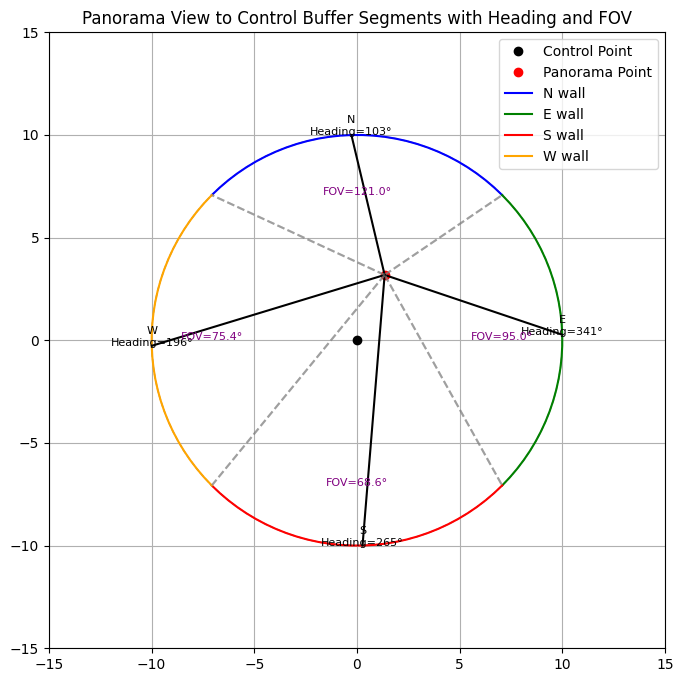

In [7]:
def single_case():
    # Parameters
    control_point = Point(0, 0)
    buffer_radius = 10
    panorama_radius = 10
    
    # Generate panorama point within 5 meters
    angle = np.random.uniform(0, 2*np.pi)
    distance = np.random.uniform(0, panorama_radius)
    panorama_point = Point(
        control_point.x + distance * np.cos(angle),
        control_point.y + distance * np.sin(angle)
    )
    
    # Partition angles for N, E, S, W segments
    segment_angles = {
        'N': (45, 135),
        'E': (315, 405),
        'S': (225, 315),
        'W': (135, 225),
    }
    colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}
    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw control buffer
    circle = Circle((control_point.x, control_point.y), buffer_radius, edgecolor='gray', fill=False, linestyle='--')
    ax.add_patch(circle)
    
    # Draw control and panorama points
    ax.plot(control_point.x, control_point.y, 'ko', label='Control Point')
    ax.plot(panorama_point.x, panorama_point.y, 'ro', label='Panorama Point')
    
    # Plot directional segments and FOV from panorama
    for direction, (start_angle, end_angle) in segment_angles.items():
        pts = get_segment_points(control_point, buffer_radius, start_angle, end_angle)
        color = colors[direction]
    
        # Plot segment arc
        xs = [p.x for p in pts]
        ys = [p.y for p in pts]
        ax.plot(xs, ys, color=color, label=f"{direction} wall")
    
        # Get segment endpoints and center
        start_pt, end_pt = pts[0], pts[-1]
        center_idx = len(pts) // 2
        center_pt = pts[center_idx]
    
        # Heading line (panorama to segment center)
        ax.plot(
            [panorama_point.x, center_pt.x],
            [panorama_point.y, center_pt.y],
            color='black',
            linewidth=1.5
        )
    
        # FOV dashed lines (panorama to segment ends)
        ax.plot(
            [panorama_point.x, start_pt.x],
            [panorama_point.y, start_pt.y],
            color='gray', linestyle='--', alpha=0.5
        )
        ax.plot(
            [panorama_point.x, end_pt.x],
            [panorama_point.y, end_pt.y],
            color='gray', linestyle='--', alpha=0.5
        )
    
        # Annotate heading angle
        heading_angle = calculate_heading(panorama_point, center_pt)
        ax.text(center_pt.x, center_pt.y, f'{direction}\nHeading={int(heading_angle)}°',
                fontsize=8, ha='center', color='black')
    
        # Annotate FOV
        fov_angle = calculate_fov(panorama_point, start_pt, end_pt)
        label_x = (start_pt.x + end_pt.x) / 2
        label_y = (start_pt.y + end_pt.y) / 2
        ax.text(label_x, label_y, f'FOV={fov_angle:.1f}°',
                fontsize=8, ha='center', color='purple')
    
    # Final plot settings
    ax.set_aspect('equal')
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.legend()
    ax.set_title("Panorama View to Control Buffer Segments with Heading and FOV")
    plt.grid(True)
    plt.show()

single_case()

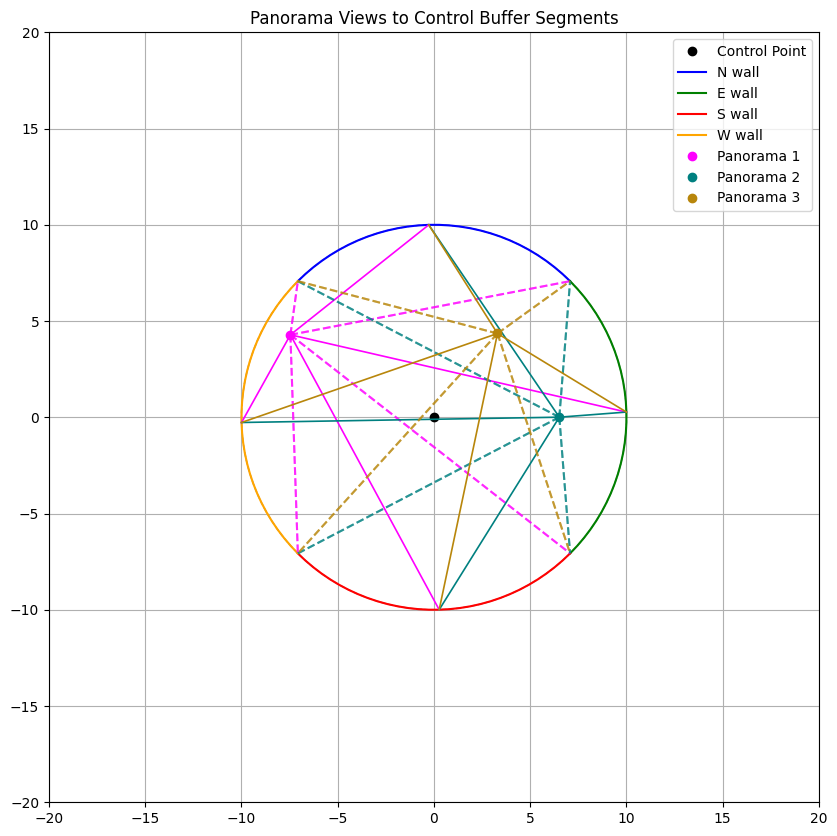

Panorama ID Segment  Heading (°)  FOV (°)
         P1       E        347.1     48.9
         P1       N         38.5     71.2
         P1       S        298.4     50.0
         P1       W        240.9    170.1
         P2       E          4.4    171.0
         P2       N        124.2     67.0
         P2       S        238.0     67.0
         P2       W        181.0     55.0
         P3       E        328.6    107.5
         P3       N        122.3    129.5
         P3       S        258.1     60.5
         P3       W        199.2     62.5


In [3]:
def run_simulation_and_plot():
    # --- Parameters ---
    control_point = Point(0, 0)
    buffer_radius = 10
    panorama_radius = 10
    n_panoramas = 3
    np.random.seed(1) # Use the same seed as the original notebook for reproducibility

    # --- Generate Panorama Points ---
    panorama_points = []
    for _ in range(n_panoramas):
        angle = np.random.uniform(0, 2 * np.pi)
        distance = np.random.uniform(buffer_radius / 2, panorama_radius)
        panorama_points.append(Point(
            control_point.x + distance * np.cos(angle),
            control_point.y + distance * np.sin(angle)
        ))

    # --- Segment Definitions ---
    segment_angles = {'N': (45, 135), 'E': (315, 405), 'S': (225, 315), 'W': (135, 225)}
    colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}
    panorama_colors = ['magenta', 'teal', 'darkgoldenrod']

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 10))
    circle = Circle((control_point.x, control_point.y), buffer_radius, edgecolor='gray', fill=False, linestyle='--')
    ax.add_patch(circle)
    ax.plot(control_point.x, control_point.y, 'ko', label='Control Point')
    
    records = []
    
    # Plot segments first and collect labels once
    for direction, (start_angle, end_angle) in segment_angles.items():
        pts = get_segment_points(control_point, buffer_radius, start_angle, end_angle)
        ax.plot([p.x for p in pts], [p.y for p in pts], color=colors[direction], label=f"{direction} wall")

    for i, pano in enumerate(panorama_points):
        ax.plot(pano.x, pano.y, 'o', color=panorama_colors[i], label=f'Panorama {i+1}')
        for direction, (start_angle, end_angle) in segment_angles.items():
            pts = get_segment_points(control_point, buffer_radius, start_angle, end_angle)
            start_pt, end_pt = pts[0], pts[-1]
            center_pt = pts[len(pts) // 2]

            # Lines to segment
            ax.plot([pano.x, center_pt.x], [pano.y, center_pt.y], color=panorama_colors[i], linewidth=1.2)
            ax.plot([pano.x, start_pt.x], [pano.y, start_pt.y], color=panorama_colors[i], linestyle='--', alpha=0.6)
            ax.plot([pano.x, end_pt.x], [pano.y, end_pt.y], color=panorama_colors[i], linestyle='--', alpha=0.6)

            # Data collection
            heading = calculate_heading(pano, center_pt)
            fov = calculate_fov(pano, start_pt, end_pt)
            records.append({
                'Panorama ID': f'P{i+1}', 'Segment': direction,
                'Heading (°)': round(heading, 1), 'FOV (°)': round(fov, 1)
            })

    # --- Final Plot Settings ---
    ax.set_aspect('equal')
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.legend()
    ax.set_title("Panorama Views to Control Buffer Segments")
    plt.grid(True)
    plt.show()

    # --- Display Table ---
    df = pd.DataFrame(records).sort_values(by=['Panorama ID', 'Segment'])
    print(df.to_string(index=False))

run_simulation_and_plot()

### 4. Handling FOV > 120°
When the required FOV to cover a segment is too wide for a single photo, we can split it into multiple, smaller views. This section demonstrates how to calculate and visualize these sub-views.

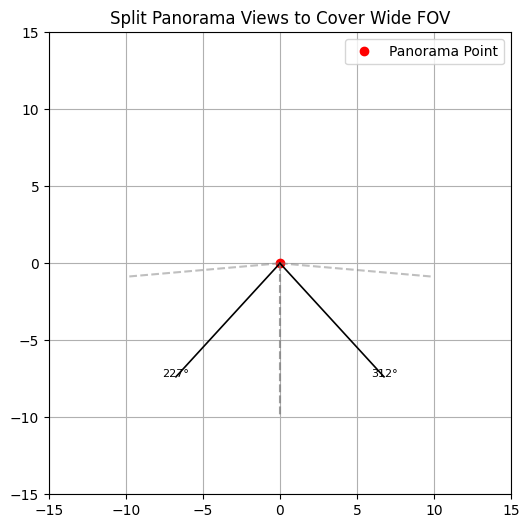

Sub-views:
  View 1: Heading = 227.5°, FOV = 85.0°
  View 2: Heading = 312.5°, FOV = 85.0°


In [4]:
def plot_fov_cones(ax, panorama_point, views, radius=10, color='gray'):
    """Plots FOV cones for split views."""
    ax.plot(panorama_point.x, panorama_point.y, 'ro', label='Panorama Point')
    for heading, fov in views:
        h_rad = np.radians(heading)
        half_fov = np.radians(fov / 2)
        
        start_angle = h_rad - half_fov
        end_angle = h_rad + half_fov
        
        start_pt = Point(panorama_point.x + radius * np.cos(start_angle), panorama_point.y + radius * np.sin(start_angle))
        end_pt = Point(panorama_point.x + radius * np.cos(end_angle), panorama_point.y + radius * np.sin(end_angle))
        center_pt = Point(panorama_point.x + radius * np.cos(h_rad), panorama_point.y + radius * np.sin(h_rad))

        ax.plot([panorama_point.x, start_pt.x], [panorama_point.y, start_pt.y], linestyle='--', alpha=0.5, color=color)
        ax.plot([panorama_point.x, end_pt.x], [panorama_point.y, end_pt.y], linestyle='--', alpha=0.5, color=color)
        ax.plot([panorama_point.x, center_pt.x], [panorama_point.y, center_pt.y], color='black', linewidth=1.2)
        ax.text(center_pt.x, center_pt.y, f'{int(heading)}°', fontsize=8, ha='center')

def run_fov_split_example():
    panorama_point = Point(0, 0)
    main_heading = 270
    required_fov = 170
    max_allowed_fov = 120

    views = split_fov(main_heading, required_fov, max_fov=max_allowed_fov)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_fov_cones(ax, panorama_point, views, radius=10)
    
    ax.set_aspect('equal')
    ax.set_xlim(panorama_point.x - 15, panorama_point.x + 15)
    ax.set_ylim(panorama_point.y - 15, panorama_point.y + 15)
    ax.legend()
    ax.set_title("Split Panorama Views to Cover Wide FOV")
    plt.grid(True)
    plt.show()

    print("Sub-views:")
    for i, (h, f) in enumerate(views, 1):
        print(f"  View {i}: Heading = {round(h, 2)}°, FOV = {round(f, 2)}°")

run_fov_split_example()